## Import the key libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt # for plotting
# install it from: https://pytorch.org/get-started/locally/
import torch # the most used deep learning framework next to TensorFlow
import time # measure time

## GPU

Basic GPU monitoring informations that can be useful. `!nvidia-smi` (NVIDIA Management Library) can be used to get a summary table. Unfortunately, it cannot be called directly, so other libraries must be used to monitor the gpu in the program. Currently, it only works stably on nvidia GPUs. Currently, it only works stably on Nvidia GPUs. To take advantage of the GPU, Cuda Toolkit "https://developer.nvidia.com/cuda-downloads" needs to be installed first.

In [2]:
!nvidia-smi

Sun Sep 17 21:40:04 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 537.13                 Driver Version: 537.13       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3090      WDDM  | 00000000:01:00.0 Off |                  N/A |
|  0%   34C    P8              12W / 350W |      0MiB / 24576MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## PyTorch

At its core PyTorch provides two features:
1.   An n-dimensional Tensor, similar to NumPy but switches easily between CPU and GPUs.
2.   Automatic differentiation for building and training (neural) networks.


Let's take a look on some common features: \\
- `numpy.ndarray` vs `torch.tensor` \\
- `numpy.ones` vs `torch.ones` \\
- `numpy.zeros` vs `torch.zeros` \\
- `numpy.copy()` vs `torch.clone()` \\
- `.reshape` vs `.view` (numpy vs torch) \\
- `numpy.linalg.inv()` vs `torch.inverse()` \\
- `torch.from_numpy()` \\
- `torch.where()` \\

### Numpy vs Torch

Two additional parameters can be specified for the Torch tensor. The device can be 'cpu' or cuda, where the number can be selected. The need for a gradient increases its space requirements but is necessary for training.

In [3]:
#install cudatoolkit
my_tensor = torch.tensor(data=[2.5], dtype=torch.float64, device='cuda:0', requires_grad=True)

In [4]:
numpy_array = np.array([[1.0,3.2,0],[3.3,4.1,0]], dtype=np.float16)
print(f'numpy_array type: {type(numpy_array)}')
tensor = torch.from_numpy(numpy_array)
print(f'tensor type: {type(tensor)}')

numpy_array type: <class 'numpy.ndarray'>
tensor type: <class 'torch.Tensor'>


In [5]:
print(tensor.shape)
print(tensor.size(0)) # same as .shape and you can specify the dimension
print(tensor.dim())

torch.Size([2, 3])
2
2


#### Difference in execution time - numpy vs pytorch

The comparison should consider the conversion time and the time of data movement to/from the GPU memory. Because of the copy times, when possible it is worth initializing variables directly on the GPU. 

- `%%time`-total execution time of the cell, 
- `%time` -next line execution time, only for Win64 (Win32 chase=0)
- Compiler time: shows up if>0.1 s
- Wall time: time diff.(kernel start and end)
- user: code execution time (maybe more than wall time in paralell case)
- sys: pre and after processes (memory allocation...)
- CPU time is user time + sys time


In [6]:
matrix_1 = np.random.randn(5000,5000)
matrix_2 = np.random.randn(5000,5000)

In [7]:
%%time 
res_numpy = np.dot(matrix_1, matrix_2)
print(res_numpy[0])

[-25.52769587 -20.15091784 -81.99992774 ... -45.12226572 115.02533219
  38.42268671]
CPU times: total: 5.17 s
Wall time: 424 ms


In [8]:
torch_mx_1 = torch.from_numpy(matrix_1).float().cuda()
torch_mx_2 = torch.from_numpy(matrix_2).float().cuda()

In [9]:
%%time 
# torch_mx_1 = torch.from_numpy(matrix_1).float().cuda()
# torch_mx_2 = torch.from_numpy(matrix_2).float().cuda()
res_pytorch = torch.mm(torch_mx_1, torch_mx_2)
print(res_pytorch[0])

tensor([-25.5277, -20.1509, -82.0000,  ..., -45.1223, 115.0253,  38.4226],
       device='cuda:0')
CPU times: total: 344 ms
Wall time: 650 ms


#### Matrix inverse, determinant and transpose

Try different types and devices and check accuracy and speed.

In [10]:
n = np.array([[2.,3.],[5.,5.]], dtype=np.float32)
p = torch.tensor([[2.,3.],[5.,5.]], dtype=torch.float32, device='cuda:0')

print(f'numpy inverse:\n {np.linalg.inv(n)}')
print(f'torch inverse:\n {p.inverse()}')
print()

print(f'numpy determinant:\n {np.linalg.det(n)}')
print(f'torch determinant:\n {torch.det(p)}')
print()

print(f'numpy transpose:\n {n.T}')
print(f'torch transpose:\n {p.t()}')
print()


numpy inverse:
 [[-1.   0.6]
 [ 1.  -0.4]]
torch inverse:
 tensor([[-1.0000,  0.6000],
        [ 1.0000, -0.4000]], device='cuda:0')

numpy determinant:
 -5.0
torch determinant:
 -4.999999523162842

numpy transpose:
 [[2. 5.]
 [3. 5.]]
torch transpose:
 tensor([[2., 5.],
        [3., 5.]], device='cuda:0')



#### Reshape

In [11]:
n = np.array([[2.,3.,0.,2.],[5.,5.,3.,2.]])
p = torch.tensor([[2.,3.,0.,2.],[5.,5.,3.,2.]], device='cuda:0')

print(n.reshape((1,4,2)))
print(p.view((2,4,1)))
print(p.reshape((4,2,1)))
p

[[[2. 3.]
  [0. 2.]
  [5. 5.]
  [3. 2.]]]
tensor([[[2.],
         [3.],
         [0.],
         [2.]],

        [[5.],
         [5.],
         [3.],
         [2.]]], device='cuda:0')
tensor([[[2.],
         [3.]],

        [[0.],
         [2.]],

        [[5.],
         [5.]],

        [[3.],
         [2.]]], device='cuda:0')


tensor([[2., 3., 0., 2.],
        [5., 5., 3., 2.]], device='cuda:0')

####  Parallel calculations

GPU calculations do not take CPU time.

A simple parallel task where values smaller than 0 are replaced by pi

In [12]:
x_torch = torch.randn(10000, 10000, dtype=torch.double, device='cuda:0')
x_numpy = np.random.randn(10000,10000)
# directly on GPU
S2 = torch.Size((100, 100))
x = torch.cuda.HalfTensor(S2)
torch.randn(S2, out=x)

tensor([[ 0.3308,  0.7075,  1.6758,  ...,  1.1602, -0.1144, -1.2949],
        [ 0.9766,  1.7588, -0.4980,  ...,  1.0010,  1.4658, -1.0625],
        [-0.5225,  0.8003, -0.4739,  ..., -0.1239, -0.8081, -1.4629],
        ...,
        [-2.7793,  0.2296, -1.1104,  ..., -1.1719,  1.0391, -0.6201],
        [ 1.0918,  0.0592,  1.3613,  ...,  0.2253, -0.3237,  0.3560],
        [-0.5684, -0.6436, -0.8867,  ...,  0.2896, -0.2642,  1.4541]],
       device='cuda:0', dtype=torch.float16)

In [13]:
%%time
tstart = time.time()
x_torch=torch.where(x_torch > 0, x_torch, torch.pi)
thalf = time.time()
x_numpy=np.where(x_numpy > 0, x_numpy, np.pi)
tend = time.time()
print('GPU calculation time pytorch: ',thalf-tstart, ' s')
print('CPU calculation time numpy: ',tend-thalf, ' s')

GPU calculation time pytorch:  0.0  s
CPU calculation time numpy:  0.19516634941101074  s
CPU times: total: 78.1 ms
Wall time: 195 ms


# Computation graphs and Autograd
In the case of learning systems, we often need the value of the gradient(primarily its direction) `requires_grad=true`.

In this section, we examine a general directed graph, which clearly illustrates the operation of the neural networks and can greatly help in understanding them.

In [14]:
x = torch.tensor(5., requires_grad=True)

$ y = 3x^2 + 4x + 2$

`x` = `5`  
$ y = 3*5^2 + 4*5 + 2 $\
$ y = 3*25 + 20 + 2$\
$ y = 75 + 20 + 2 $\
$ y = 97 $


In [15]:
y = 3*x**2 + 4*x + 2
y

tensor(97., grad_fn=<AddBackward0>)

The `backward()` method is used to compute the gradient during the backward pass in a neural network.

The derivative of `y` with respect to the variable `x`.\
$\frac{dy}{dx} = 2*3x + 4 = 6x + 4$\
`x` = `5`

$6x + 4 = 6*5 + 4 = 30 + 4 = 34$


In [16]:
y.backward()
x.grad

tensor(34.)

PyTorch accumulates the derivatives (gradients) on each subsequent backward passes. This is convinient during training **R**ecurrent **N**eural **N**etworks \\
To set it zero in each iteration you can use `grad.zero_` function on a `Tensor`.


In [17]:
x = torch.tensor(5., requires_grad=True)

for i in range(3):
  y = 3*x**2 + 4*x + 2
  y.backward()

  print(x.grad)
  x.grad.zero_() ## pytorch accumulates the derivatives by default


tensor(34.)
tensor(34.)
tensor(34.)


`torch.tensor` can not converted to numpy if grad is True, to convert a `torch.tensor` to `numpy.ndarray` you have to explicitly remove the computational graph from the tensor using `detach()` command

In [18]:
x = torch.tensor(5., requires_grad=False)
np_x = x.numpy()

In [19]:
np_x = x.detach().numpy()
print(f'np_x type: {type(np_x)}')
print(f'np_x: {np_x}')

np_x type: <class 'numpy.ndarray'>
np_x: 5.0


A bit more complex calculation of gradients

$e = \underbrace{(a * b)}_\text{u} + \underbrace{c * \underbrace{log(d)}_\text{w}}_\text{v}$

digraph G {
	e
	u
	v
	w
	a [color=transparent]
	b [color=transparent]
	c [color=transparent]
	d [color=transparent]
	e -> u [dir=back]
	e -> v [dir=back]
	v -> w [dir=back]
	v -> c [dir=back]
	u -> a [dir=back]
	u -> b [dir=back]
	w -> d [dir=back]
}



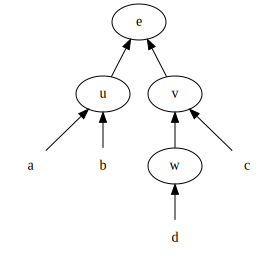

In [20]:
import graphviz #install graphviz, python-graphviz
g = graphviz.Digraph('G', filename='hello.gv')
g.node('e')
g.node('u')
g.node('v')
g.node('w')
g.node('a', color='transparent')
g.node('b', color='transparent')
g.node('c', color='transparent')
g.node('d', color='transparent')
g.edge('e', 'u', dir='back')
g.edge('e', 'v', dir='back')
g.edge('v', 'w', dir='back')
g.edge('v', 'c', dir='back')
g.edge('u', 'a', dir='back')
g.edge('u', 'b', dir='back')
g.edge('w', 'd', dir='back')
print(g.source)
g

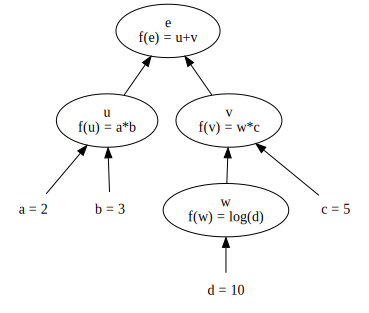

In [21]:
g = graphviz.Digraph('G', filename='hello.gv')
g.node('e\nf(e) = u+v')
g.node('u\nf(u) = a*b')
g.node('v\nf(v) = w*c')
g.node('w\nf(w) = log(d)')
g.node('a = 2', color='transparent')
g.node('b = 3', color='transparent')
g.node('c = 5', color='transparent')
g.node('d = 10', color='transparent')
g.edge('e\nf(e) = u+v', 'u\nf(u) = a*b', dir='back')
g.edge('e\nf(e) = u+v', 'v\nf(v) = w*c', dir='back')
g.edge('v\nf(v) = w*c', 'w\nf(w) = log(d)', dir='back')
g.edge('v\nf(v) = w*c', 'c = 5', dir='back')
g.edge('u\nf(u) = a*b', 'a = 2', dir='back')
g.edge('u\nf(u) = a*b', 'b = 3', dir='back')
g.edge('w\nf(w) = log(d)', 'd = 10', dir='back')
g

In case of forward-pass (of backpropagation) we have to replace the variables in the equation:

$e = \underbrace{(a * b)}_\text{u} + \underbrace{c * \underbrace{log(d)}_\text{w}}_\text{v} = (2 * 3) + (5 * \underbrace{log(10)}_\text{1}) = 11$

To calculate the backward-pass simply let `torch` do the math and calculate the derivative of **`e`** with respect to the inputs leading to **`e`**

$\frac{\partial e}{\partial a} = ?$ \\
$\frac{\partial e}{\partial b} = ?$ \\
$\frac{\partial e}{\partial c} = ?$ \\
$\frac{\partial e}{\partial d} = ?$

In [22]:
a = torch.tensor(2., requires_grad=True)
b = torch.tensor(3., requires_grad=True)
c = torch.tensor(5., requires_grad=True)
d = torch.tensor(10., requires_grad=True)


# e = (a * b) + c * torch.log10(d)

u = a*b
w = torch.log10(d)
v = c * w

e = u + v
e
u.retain_grad() 
w.retain_grad() 
v.retain_grad() 

e.retain_grad() 

In [23]:
e.backward()
print(f"a:\n\t is_leaf: {a.is_leaf} \n\t grad_fn: {a.grad_fn} \n\t grad: {a.grad}")
print(f"b:\n\t is_leaf: {b.is_leaf} \n\t grad_fn: {b.grad_fn} \n\t grad: {b.grad}")
print(f"c:\n\t is_leaf: {c.is_leaf} \n\t grad_fn: {c.grad_fn} \n\t grad: {c.grad}")
print(f"d:\n\t is_leaf: {d.is_leaf} \n\t grad_fn: {d.grad_fn} \n\t grad: {d.grad}")
print()
print(f"u:\n\t is_leaf: {u.is_leaf} \n\t grad_fn: {u.grad_fn} \n\t grad: {u.grad}")
print(f"w:\n\t is_leaf: {w.is_leaf} \n\t grad_fn: {w.grad_fn} \n\t grad: {w.grad}")
print(f"v:\n\t is_leaf: {v.is_leaf} \n\t grad_fn: {v.grad_fn} \n\t grad: {v.grad}")
print()
print(f"e:\n\t is_leaf: {e.is_leaf} \n\t grad_fn: {e.grad_fn} \n\t grad: {e.grad}")

a:
	 is_leaf: True 
	 grad_fn: None 
	 grad: 3.0
b:
	 is_leaf: True 
	 grad_fn: None 
	 grad: 2.0
c:
	 is_leaf: True 
	 grad_fn: None 
	 grad: 1.0
d:
	 is_leaf: True 
	 grad_fn: None 
	 grad: 0.21714723110198975

u:
	 is_leaf: False 
	 grad_fn: <MulBackward0 object at 0x000001EED2C77F70> 
	 grad: 1.0
w:
	 is_leaf: False 
	 grad_fn: <Log10Backward0 object at 0x000001EED2C1EE60> 
	 grad: 5.0
v:
	 is_leaf: False 
	 grad_fn: <MulBackward0 object at 0x000001EED2C77F70> 
	 grad: 1.0

e:
	 is_leaf: False 
	 grad_fn: <AddBackward0 object at 0x000001EED2C77F70> 
	 grad: 1.0


In [24]:
"""
TASK:
Calculate the partial derivatives of `u`, `w` and `v` variables
"""

'\nTASK:\nCalculate the partial derivatives of `u`, `w` and `v` variables\n'

In [25]:
from IPython.display import display, Math
display(Math(fr'\frac{{\partial e}}{{\partial a}} = {a.grad.item()}'))
print()
display(Math(fr'\frac{{\partial e}}{{\partial b}} = {b.grad.item()}'))
print()
display(Math(fr'\frac{{\partial e}}{{\partial c}} = {c.grad.item()}'))
print()
display(Math(fr'\frac{{\partial e}}{{\partial d}} = {d.grad.item()}'))
print()
print()
display(Math(fr'\frac{{\partial e}}{{\partial u}} = {u.grad.item()}'))
print()
display(Math(fr'\frac{{\partial e}}{{\partial w}} = {w.grad.item()}'))
print()
display(Math(fr'\frac{{\partial e}}{{\partial v}} = {v.grad.item()}'))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [26]:
x1 = torch.tensor(2., requires_grad=True)
x2 = torch.tensor(5., requires_grad=True)

y_hat = x1 ** 3 + x2 ** 2
y_hat

tensor(33., grad_fn=<AddBackward0>)

In [27]:
y_hat.backward()
print(f'x1: {x1.grad}  -- 3*(x1^2) = 3 * 4')
print(f'x2: {x2.grad}  -- 2*(x2^1) = 2 * 5')

x1: 12.0  -- 3*(x1^2) = 3 * 4
x2: 10.0  -- 2*(x2^1) = 2 * 5


# Loading datasets via **Pandas**

In this example, we will look at a basic data processing and visualization using the Panda library (pip/conda install pandas). 

`Car_sales.csv` can be downloaded from Canvas \\
official Kaggle source: https://www.kaggle.com/abhi827/car-sales/data?select=Car_sales.csv

Read the data with default parameter:
**pd.read_csv("Car_sales.csv")** - https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html

Most common parameters:
- header and name
    - Example:
    Import dataset where \\
    **`header` = `None`** (header row does not exist) **or `0`** (for replaceing) \\
    **`names` = `list_of_strings`** (will be the new header)
- separator character
    - Example:
    Import dataset when the separator is `','`  \\
    **`sep` = `','`** 
- missing values
    - Example:
    Import dataset when missing values are noted as empty space\\
    **`na_values` = `''`** 


In [28]:
import pandas as pd

header_values = ['Manufacturer','Model','Sales_in_thousands','4__year_resale_value','Vehicle_type','Price_in_thousands','Engine_size','Horsepower','Wheelbase','Width','Length','Curb_weight','Fuel_capacity','Fuel_efficiency','Latest_Launch','Power_perf_factor']
df= pd.read_csv("Car_sales.csv", header=0, names=header_values, sep=',', na_values='')
df.head(6)

,Manufacturer,Model,Sales_in_thousands,4__year_resale_value,Vehicle_type,Price_in_thousands,Engine_size,Horsepower,Wheelbase,Width,Length,Curb_weight,Fuel_capacity,Fuel_efficiency,Latest_Launch,Power_perf_factor
0,Acura,Integra,16.919,16.360,Passenger,21.50,1.8,140.0,101.2,67.3,172.4,2.639,13.2,28.0,2/2/2012,58.280150
1,Acura,TL,39.384,19.875,Passenger,28.40,3.2,225.0,108.1,70.3,192.9,3.517,17.2,25.0,6/3/2011,91.370778
2,Acura,CL,14.114,18.225,Passenger,NaN,3.2,225.0,106.9,70.6,192.0,3.470,17.2,26.0,1/4/2012,NaN
3,Acura,RL,8.588,29.725,Passenger,42.00,3.5,210.0,114.6,71.4,196.6,3.850,18.0,22.0,3/10/2011,91.389779
4,Audi,A4,20.397,22.255,Passenger,23.99,1.8,150.0,102.6,68.2,178.0,2.998,16.4,27.0,10/8/2011,62.777639
5,Audi,A6,18.780,23.555,Passenger,33.95,2.8,200.0,108.7,76.1,192.0,3.561,18.5,22.0,8/9/2011,84.565105


## Visualisation and description

Data overview:
- **df.head()** - first 5 data
- **df.tail()** - last 5 data
- **df.describe()** - simple statistic
- **df.info()** - df.shape, df.dtypes, df.isna(), memory
    - df.shape - data size and heads
    - df.dtypes - type of each coulomb
    - df.isna().sum().sum() - number of NaN parameters
- **df['Engine_size']** - specify a subset
- **df['Engine_size'].value_counts** - count based on type

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 157 entries, 0 to 156
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Manufacturer          157 non-null    object 
 1   Model                 157 non-null    object 
 2   Sales_in_thousands    157 non-null    float64
 3   4__year_resale_value  121 non-null    float64
 4   Vehicle_type          157 non-null    object 
 5   Price_in_thousands    155 non-null    float64
 6   Engine_size           156 non-null    float64
 7   Horsepower            156 non-null    float64
 8   Wheelbase             156 non-null    float64
 9   Width                 156 non-null    float64
 10  Length                156 non-null    float64
 11  Curb_weight           155 non-null    float64
 12  Fuel_capacity         156 non-null    float64
 13  Fuel_efficiency       154 non-null    float64
 14  Latest_Launch         157 non-null    object 
 15  Power_perf_factor     1

In [30]:
df.describe()

,Sales_in_thousands,4__year_resale_value,Price_in_thousands,Engine_size,Horsepower,Wheelbase,Width,Length,Curb_weight,Fuel_capacity,Fuel_efficiency,Power_perf_factor
count,157.000000,121.000000,155.000000,156.000000,156.000000,156.000000,156.000000,156.000000,155.000000,156.000000,154.000000,155.000000
mean,52.998076,18.072975,27.390755,3.060897,185.948718,107.487179,71.150000,187.343590,3.378026,17.951923,23.844156,77.043591
std,68.029422,11.453384,14.351653,1.044653,56.700321,7.641303,3.451872,13.431754,0.630502,3.887921,4.282706,25.142664
min,0.110000,5.160000,9.235000,1.000000,55.000000,92.600000,62.600000,149.400000,1.895000,10.300000,15.000000,23.276272
25%,14.114000,11.260000,18.017500,2.300000,149.500000,103.000000,68.400000,177.575000,2.971000,15.800000,21.000000,60.407707
50%,29.450000,14.180000,22.799000,3.000000,177.500000,107.000000,70.550000,187.900000,3.342000,17.200000,24.000000,72.030917
75%,67.956000,19.875000,31.947500,3.575000,215.000000,112.200000,73.425000,196.125000,3.799500,19.575000,26.000000,89.414878
max,540.561000,67.550000,85.500000,8.000000,450.000000,138.700000,79.900000,224.500000,5.572000,32.000000,45.000000,188.144323


In [31]:
df['Engine_size'].value_counts(ascending=True)

Engine_size
2.9     1
1.5     1
4.2     1
5.4     1
1.6     1
8.0     1
1.0     1
5.0     2
4.3     2
3.9     2
5.2     2
4.7     2
5.7     2
2.8     3
2.2     4
3.1     4
2.7     4
1.9     5
3.3     5
3.2     6
2.3     6
3.4     7
4.0     7
1.8     8
3.8     8
3.5     8
4.6     9
2.5    11
2.4    11
3.0    14
2.0    17
Name: count, dtype: int64

#### Dealing with missing values:
- padding with zeros
- averaging 
- most common value
- random distribution sampling
- removing (generally applicable, losing data)
- special rules

On your dataset run `dropna` function to remove all NaN by deleting the entire row (more details: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.dropna.html)
To specify which column(s) is consider in `dropna` function use `subset` parameter 

In [32]:
df = df.dropna(subset=['Price_in_thousands'])
df.head()
df.describe()

,Sales_in_thousands,4__year_resale_value,Price_in_thousands,Engine_size,Horsepower,Wheelbase,Width,Length,Curb_weight,Fuel_capacity,Fuel_efficiency,Power_perf_factor
count,155.000000,119.000000,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000,154.000000,155.000000,153.000000,155.000000
mean,53.245832,18.059370,27.390755,3.060000,185.696774,107.490968,71.153548,187.313548,3.377429,17.956774,23.830065,77.043591
std,68.397550,11.549233,14.351653,1.047979,56.796444,7.665925,3.462776,13.470034,0.632515,3.900050,4.293187,25.142664
min,0.110000,5.160000,9.235000,1.000000,55.000000,92.600000,62.600000,149.400000,1.895000,10.300000,15.000000,23.276272
25%,14.074500,11.250000,18.017500,2.300000,149.000000,103.000000,68.400000,177.550000,2.969000,15.800000,21.000000,60.407707
50%,29.450000,14.010000,22.799000,3.000000,175.000000,107.000000,70.500000,187.800000,3.341000,17.200000,24.000000,72.030917
75%,68.183500,19.882500,31.947500,3.650000,215.000000,112.200000,73.450000,196.150000,3.810250,19.650000,26.000000,89.414878
max,540.561000,67.550000,85.500000,8.000000,450.000000,138.700000,79.900000,224.500000,5.572000,32.000000,45.000000,188.144323


In [33]:
import matplotlib.pyplot as plt

from pandas.plotting import scatter_matrix
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer

We can easily create new columns in the existing dataset, similarly as in `dictionary` data type

In [34]:
df['Engine_ccm'] = df['Engine_size'] * 1000
df = df.dropna(subset=['Horsepower', 'Engine_ccm'])

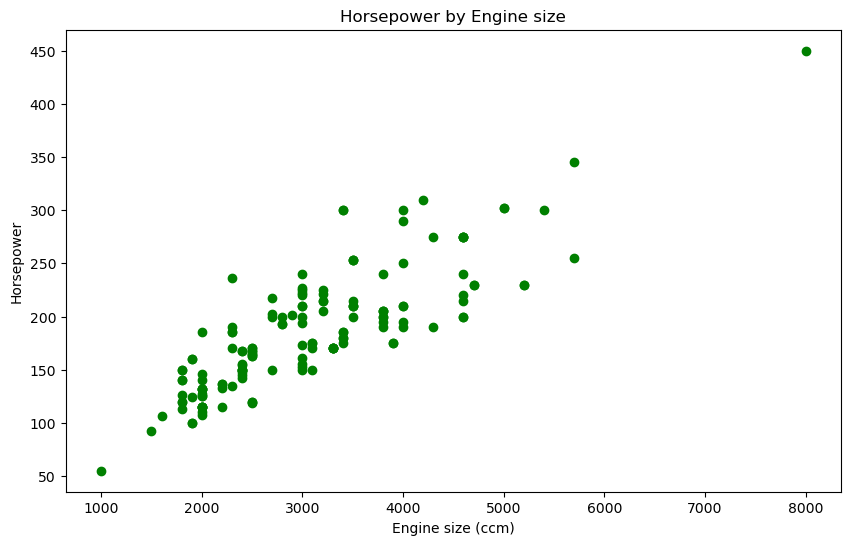

In [35]:
plt.figure(figsize=(10,6))
plt.xlabel('Engine size (ccm)')
plt.ylabel('Horsepower')
plt.title('Horsepower by Engine size')
plt.scatter(df['Engine_ccm'], df['Horsepower'], marker='o', color='g')

# Solving Linear Regression with **Normal Equation**
$\Large \theta = (X^TX)^{-1} (X^Ty)$

In [36]:
x = df[['Engine_ccm']]
y = df[['Horsepower']]

xg = x.values.reshape(-1,1)
yg = y.values.reshape(-1,1)

xg = np.concatenate((np.ones(len(x)).reshape(-1,1), x), axis=1)
def normal_equations(x,y):
    a = np.linalg.inv(np.dot(x.T, x))
    b = np.dot(x.T, y)
    theta = np.dot(a,b)
    return theta
    
theta = normal_equations(xg, yg)
print('Theta found by Normal Equation: slope = {} and intercept {}'.format(theta[1], theta[0]))

Theta found by Normal Equation: slope = [0.04542204] and intercept [46.70534028]


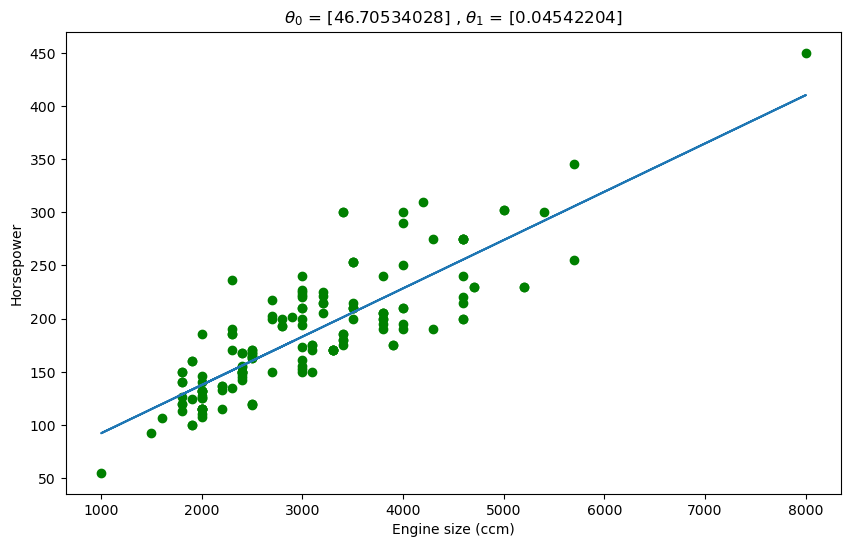

In [37]:
plt.figure(figsize=(10,6))
plt.title('$\\theta_0$ = {} , $\\theta_1$ = {}'.format(theta[0], theta[1]))
plt.plot(x.to_numpy(),np.dot(xg, theta))
plt.scatter(x,y, marker='o', color='g')
plt.xlabel('Engine size (ccm)')
plt.ylabel('Horsepower')
plt.show()




# Solving Linear Regression with **Gradient Descent**
Objective of Linear Regression is to minimize the cost function: 
<br>
$\Large J(\theta) = \frac{1}{2m} \sum\limits_{i=1}^{m} (h_\theta(x^{(i)})-y^{(i)})^2$
<br>
<br>
where the hypothesis $h_\theta(x)$ is given by the lienar model:  

$\Large h_\theta(x) = \theta^T X = \theta_1 X_1 + \theta_0 $  
<br>
In batch gradient descent, each iteration performs the update:  
$\Large \theta_j := \theta_j - \alpha \frac{1}{m} \sum\limits_{i=1}^{m}(h_\theta (x^{(i)}) - y^{(i)})x_j^{(i)}$

In [38]:
#Define cost function J
def computeCost(x, y, theta):
    m = len(y)
    h_x = x.dot(theta)
    j = np.sum(np.square(h_x - y))*(1/(2*m))
    return j

#Define Gradient Descent
def gradientDescent(x, y, theta, alpha, iteration):
    print('Running Gradient Descent...')
    j_hist = []
    m = len(y)
    for i in range(iteration):
        h_x = x.dot(theta)
        theta = theta - ((alpha/m) *((np.dot(x.T, (h_x-y) ))))
        cost = computeCost(x, y, theta)
        j_hist.append(cost)
        #print(f'Cost at iteration {i}: {cost}')
        #theta[0] = theta[0] - ((alpha/m) *(np.sum((h_x-y))))
    return theta, j_hist

In [39]:
x = df[['Engine_ccm']]
y = df[['Horsepower']]

xg = x.values.reshape(-1,1)
yg = y.values.reshape(-1,1)

xg = np.concatenate((np.ones(len(x)).reshape(-1,1), x), axis=1)

In [40]:
theta = np.random.rand(2,1)
iteration = 10000
alpha = 1e-10

theta, cost = gradientDescent(xg, yg, theta, alpha, iteration)
print('Theta found by Gradient Descent: slope = {} and intercept {}'.format(theta[1], theta[0]))

Running Gradient Descent...
Theta found by Gradient Descent: slope = [0.0590265] and intercept [0.28114502]


Text(0, 0.5, 'Cost')

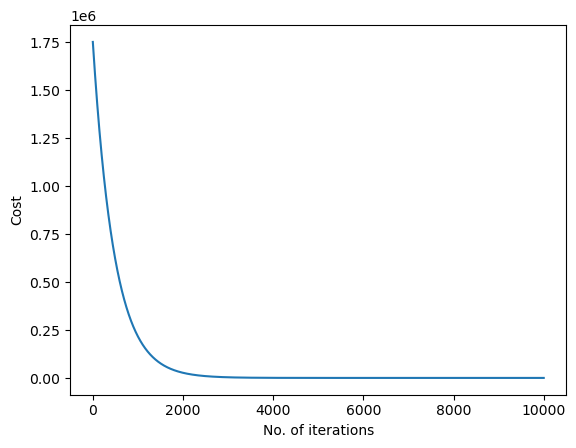

In [41]:
#theta_0 = [46.83359551] , theta_1 = [0.04544913] What are the differences?
plt.plot(cost)
plt.xlabel('No. of iterations')
plt.ylabel('Cost')

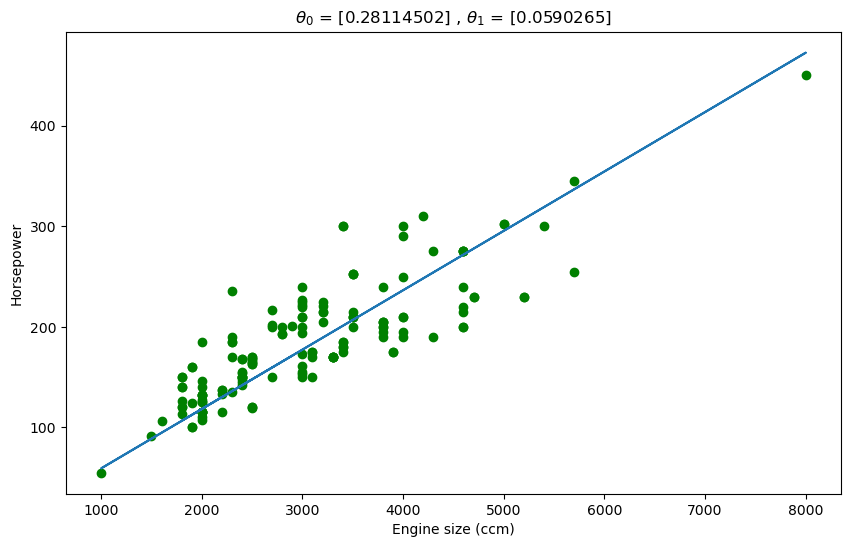

In [42]:
plt.figure(figsize=(10,6))
plt.title('$\\theta_0$ = {} , $\\theta_1$ = {}'.format(theta[0], theta[1]))
plt.scatter(x,y, marker='o', color='g')
plt.plot(x.values,np.dot(xg, theta))
plt.xlabel('Engine size (ccm)')
plt.ylabel('Horsepower')
plt.show()

In __Multiple Linear Regression__ we now use more than one dependent variable (feature). The basic idea remains the same.
Find the set of parameters that minimize the error / fits the best line. \\
#### Here we look at only the numerical solution: Gradient Descent. This is because as the number of features increases, the analytical solution becomes more ineficient.

In [43]:
df=pd.read_csv("Car_sales.csv")
df['Engine_ccm'] = df['Engine_size'] * 1000
#'Horsepower', 'Engine_ccm', 'Fuel_efficiency', 'Price_in_thousands', 'Fuel_capacity'
df = df.dropna(subset=['Horsepower', 'Engine_ccm', 'Fuel_efficiency'])
X = df[['Engine_ccm','Fuel_efficiency']]
Y = df[['Horsepower']]
x = X.values
y = Y.values

In [44]:
#Normalize features
def featureNormalize(x_m):
    mu = np.zeros((1,x_m.shape[1]))
    sigma = np.zeros((1,x_m.shape[1]))
    x_norm = x_m.astype(float)
    
    for i in range(0,len(mu)+1):
        mu[:,i] = x_m[:,i].mean()
        sigma[:,i] = x_m[:,i].std()
        x_norm[:,i] = (x_m[:,i] - mu[:,i])/sigma[:,i]
    return (x_norm, mu, sigma)

x_norm, mu, sigma = featureNormalize(x)
x_norm = np.concatenate((np.ones(len(x_norm)).reshape(-1,1), x_norm), axis=1)

In [45]:
def computeCost_m(x, y, theta):
    m = len(y)
    h_x = np.dot(x, theta)
    j = np.sum(np.square(h_x - y))/(2*m)
    return j

def gradientDescentMulti(X, Y, theta, alpha, num_iters):
    m = len(Y)
    p = np.copy(X)
    t = np.copy(theta)
    j = []
    print('Running Gradient Descent')
    for i in range(0,num_iters+1):
        cost = computeCost_m(p, Y, t)
        j.append(cost)
        #print(f'Cost at iteration {i}: {cost}')
        h_x = np.dot(p, t)
        err = h_x - Y
        for f in range(theta.size):
            t[f] = t[f] - alpha/m *(np.sum((np.dot(p[:,f].T, err))))
    return j, t

In [46]:
# theta_init = np.zeros((3, 1))
alpha = 0.01
num_iters = 1000
theta_init = np.random.rand(3, 1) #2 features + 1
cost, theta_final = gradientDescentMulti(x_norm, y, theta_init, alpha, num_iters)
print("")
print("Final theta:")
print(theta_final)

Running Gradient Descent

Final theta:
[[185.64791125]
 [ 46.36322684]
 [ -1.12311032]]


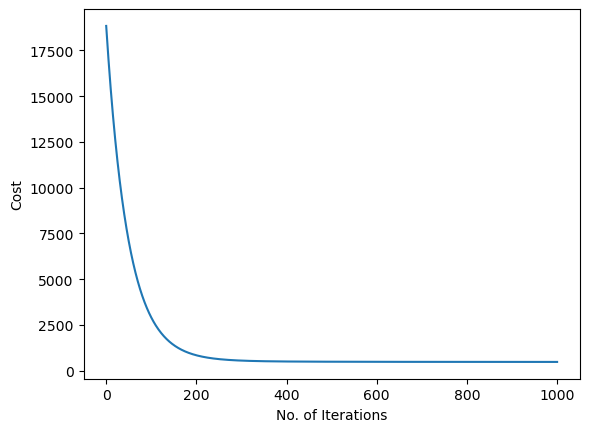

In [47]:
plt.figure()
plt.plot(cost)
plt.xlabel('No. of Iterations')
plt.ylabel('Cost')
plt.show()

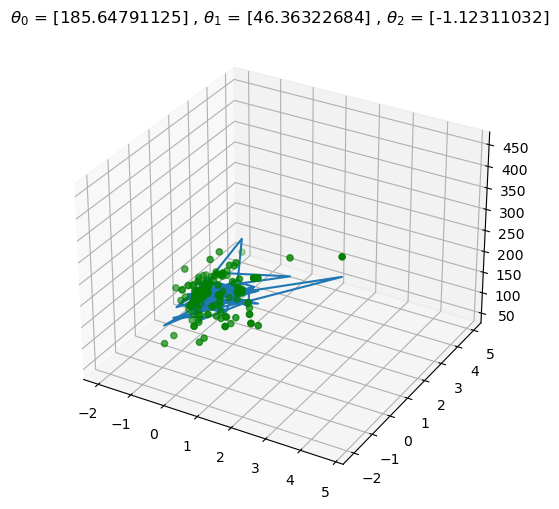

In [48]:
# 'matplotlib qt' for interactive 3D plotting in Notebooks
# %matplotlib qt
%matplotlib inline  

fig=plt.figure(figsize=(10,6))
fig3 = fig.add_subplot(projection='3d')
fig3.set_title('$\\theta_0$ = {} , $\\theta_1$ = {} , $\\theta_2$ = {}'.format(theta_final[0], theta_final[1], theta_final[2]))
fig3.scatter(x_norm[:,1],x_norm[:,2],y, marker='o', color='g')
yrep=np.array(theta_final[0]+x_norm[:,1]*theta_final[1]+x_norm[:,2]*theta_final[2])
fig3.plot(x_norm[:,1],x_norm[:,2],yrep)
plt.show()

#### Iterative sample removal is a possible method for dealing with noisy data, so that in the end the fit is only adjusted to the densest region of the data set. (application e.g.: filtering 3D point clouds)

In [49]:
xg2=xg
yg2=yg
for i1 in range(50):
    theta = normal_equations(xg2, yg2)
    max_idx=np.argmax(np.abs(np.dot(xg2,theta)-yg2),keepdims=np.ceil(xg2.size*0.05).astype(int))
    xg2=np.delete(xg2, max_idx, 0)
    yg2=np.delete(yg2, max_idx, None)
theta

array([6.17522063e+01, 3.46139933e-02])

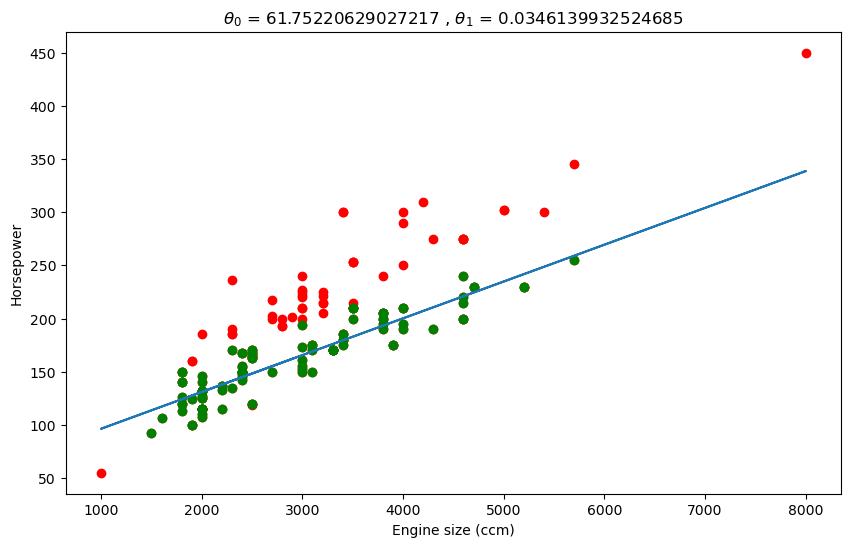

In [50]:
%matplotlib inline 
plt.figure(figsize=(10,6))
plt.title('$\\theta_0$ = {} , $\\theta_1$ = {}'.format(theta[0], theta[1]))
plt.scatter(xg[:,1],yg, marker='o', color='r')
plt.scatter(xg2[:,1],yg2, marker='o', color='g')
plt.plot(xg[:,1],np.dot(xg, theta))
plt.xlabel('Engine size (ccm)')
plt.ylabel('Horsepower')
plt.show()